# Simple Driver Comfort Analysis
*BeamNG.tech / BeamNG.drive*

## Introduction

This example will demonstrate how to use the Inertial Measurement Unit to do a simple analysis for driver comfort while driving. An IMU is a sensor that measures rotational acceleration and forces at a certain point in the vehicle. BeamNGpy provides a simulated version of such a sensor that can be placed in or on the vehicle. Contrary to real IMUs, BeamNG's are completely size and weightless, meaning they have no effect on the behavior of the vehicle and an arbitrary amount of them can be added.

## Scenario 

Our scenario contains two vehicles that are tasked with driving to a certain waypoint on the map using BeamNG's AI. The AI will be given different speed levels and aggression values. Both vehicles are equipped with an IMU placed at the headrest of the driver's seat, giving measurements about rotational acceleration and forces acting on the driver. After both vehicles arrive at their destination, the data measured for both will be plotted for comparison.

## Setup

Setting up the environment starts with importing the required classes, mainly:

* `BeamNGpy`: The backbone of the library used to manage BeamNG and communicate with the running simulation
* `Scenario`: A class representing the scenario we set up. It will contain information about which level to load and vehicles contained in the scenario.
* `Vehicle`: Each of our vehicles will be an instance of this class. It is used to represent and communicate with a vehicle in the simulation.
* `IMU`: The class implementing an IMU sensor and focus of this example. Each vehicle will have an instance of this to gather measurements.

Instances of these classes are compiled into one scenario that will then be loaded in the simulator.

Additionally, some modules and classes related to later plotting are imported.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from beamngpy import BeamNGpy, Vehicle, Scenario
from beamngpy.sensors import IMU

sns.set()  # Let seaborn apply better styling to all matplotlib graphs

The actual scenario will be set up by instantiating the `Scenario` class with an instance set on `west_coast_usa` that we name "driver_comfort". Two instances of the `Vehicle` class will be created using the ETK800 model and given unique names for later reference.

In [2]:
beamng = BeamNGpy('localhost', 64256)
beamng.open()

scenario = Scenario('west_coast_usa', 'driver_comfort')

careful = Vehicle('careful', model='etk800', licence='CAREFUL', colour='Green')
aggressive = Vehicle('aggressive', model='etk800', licence='AGGRO', colour='Red')

With two vehicles instantiated we move on to creating IMU sensor objects. These objects are placed at locations *relative to the vehicle's origin*. This means an IMU placed at (0, 0, 0) is always at the vehicle's origin, regardless of its position in the world. This, however, means placement of the IMU is best done by looking at node positions in the game's vehicle editor to get reference values. For the creation of this example, the game was started manually and the location for IMUs was determined by looking at relative node positions close to the driver's headrest of the ETK800 vehicle.

**Note**: The `debug=True` flag passed to the IMUs has no effect on the data. It merely enables debug visualization of the IMU an its readings in game.

In [3]:
careful_imu = IMU(pos=(0.73, 0.51, 0.8), debug=True)
careful.attach_sensor('careful_imu', careful_imu)

aggressive_imu = IMU(pos=(0.73, 0.51, 0.8), debug=True)
aggressive.attach_sensor('aggressive_imu', aggressive_imu)

Finally, we add the vehicles to our scenario. The locations they are placed were determined manually in the game's World Editor. The call to `scenario.make(beamng)` creates files necessary for the game to load our scenario during the simulation.

In [4]:
scenario.add_vehicle(careful, pos=(-767.1, 402.8, 142.8), rot_quat=(0, 0, 0.027, 1))
scenario.add_vehicle(aggressive, pos=(-770.1, 398.8, 142.8), rot_quat=(0, 0, 0.027, 1))

scenario.make(beamng)

We further set up two lists that will contain measurement data for both vehicles. These will later be put into a Pandas `DataFrame` for easy data analysis.

In [5]:
careful_data = []
aggressive_data = []

## Running

After our scenario is loaded in the simulator, we start the scenario letting the aggressive vehicle drive to its destination first, using a high maximum speed and high aggression value. Data from the vehicle's IMU is gathered every 30 frames for 1800 frames. Afterwards, the careful vehicle is given the same destination but a lower speed limit and lower aggression value. Its IMU will be sampled in the same manner.

In [6]:
beamng.load_scenario(scenario)
beamng.set_deterministic()
beamng.set_steps_per_second(60)
beamng.start_scenario()
beamng.pause()

beamng.switch_vehicle(aggressive)  # Switches the game's focus to the aggressive vehicle. No effect besides making it easier to watch.

aggressive.ai_set_waypoint('junction1_wp24')
aggressive.ai_set_speed(50, mode='limit')
aggressive.ai_set_aggression(1)
beamng.step(240)  # Give the vehicle some frames to get going

for t in range(0, 1800, 30):
    aggressive.poll_sensors()
    row = aggressive_imu.data
    row = [
        t,
        'aggressive',
        row['aX'],
        row['aY'],
        row['aZ'],
        row['gX'],
        row['gY'],
        row['gZ'],
    ]
    aggressive_data.append(row)
    beamng.step(30)

aggressive.ai_set_waypoint('tunnel_NE_A_1')  # Make it move away to make room for the careful car

beamng.switch_vehicle(careful)  # Switches the game's focus to the careful vehicle. No effect besides making it easier to watch.

careful.ai_set_waypoint('junction1_wp24')
careful.ai_set_speed(10, mode='limit')
careful.ai_set_aggression(0.3)
beamng.step(240)

for t in range(0, 1800, 30):
    careful.poll_sensors()
    row = careful_imu.data
    row = [
        t,
        'careful',
        row['aX'],
        row['aY'],
        row['aZ'],
        row['gX'],
        row['gY'],
        row['gZ'],
    ]
    careful_data.append(row)
    beamng.step(30)

data = careful_data + aggressive_data
df = pd.DataFrame(data, columns=['T', 'Behavior', 'aX', 'aY', 'aZ', 'gX', 'gY', 'gZ'])

beamng.close()  # Close beamng as all data was gathered

## Analysis

We analyze the data by computing the respective lengths of rotational acceleration and force vectors on each vehicle. This data is then aggregated into minimum, maximum, and mean lengths to compare both careful and aggressive measurements and later plotted to display the length of each measurement over time.

In [7]:
df['Force'] = df.apply(lambda r: np.linalg.norm([r['gX'], r['gY'], r['gZ']]), axis=1)
df['Rotation'] = df.apply(lambda r: np.linalg.norm([r['aX'], r['aY'], r['aZ']]), axis=1)
df[['Behavior', 'Force', 'Rotation']].groupby('Behavior').agg(['min', 'max', 'mean'])

Force                         Rotation                    
                 min         max       mean       min       max      mean
Behavior                                                                 
aggressive  4.879156  114.671132  22.306183  0.000251  0.961356  0.201906
careful     1.038280   51.380277   7.344298  0.001908  0.506748  0.108020

<AxesSubplot:xlabel='T', ylabel='Rotation'>

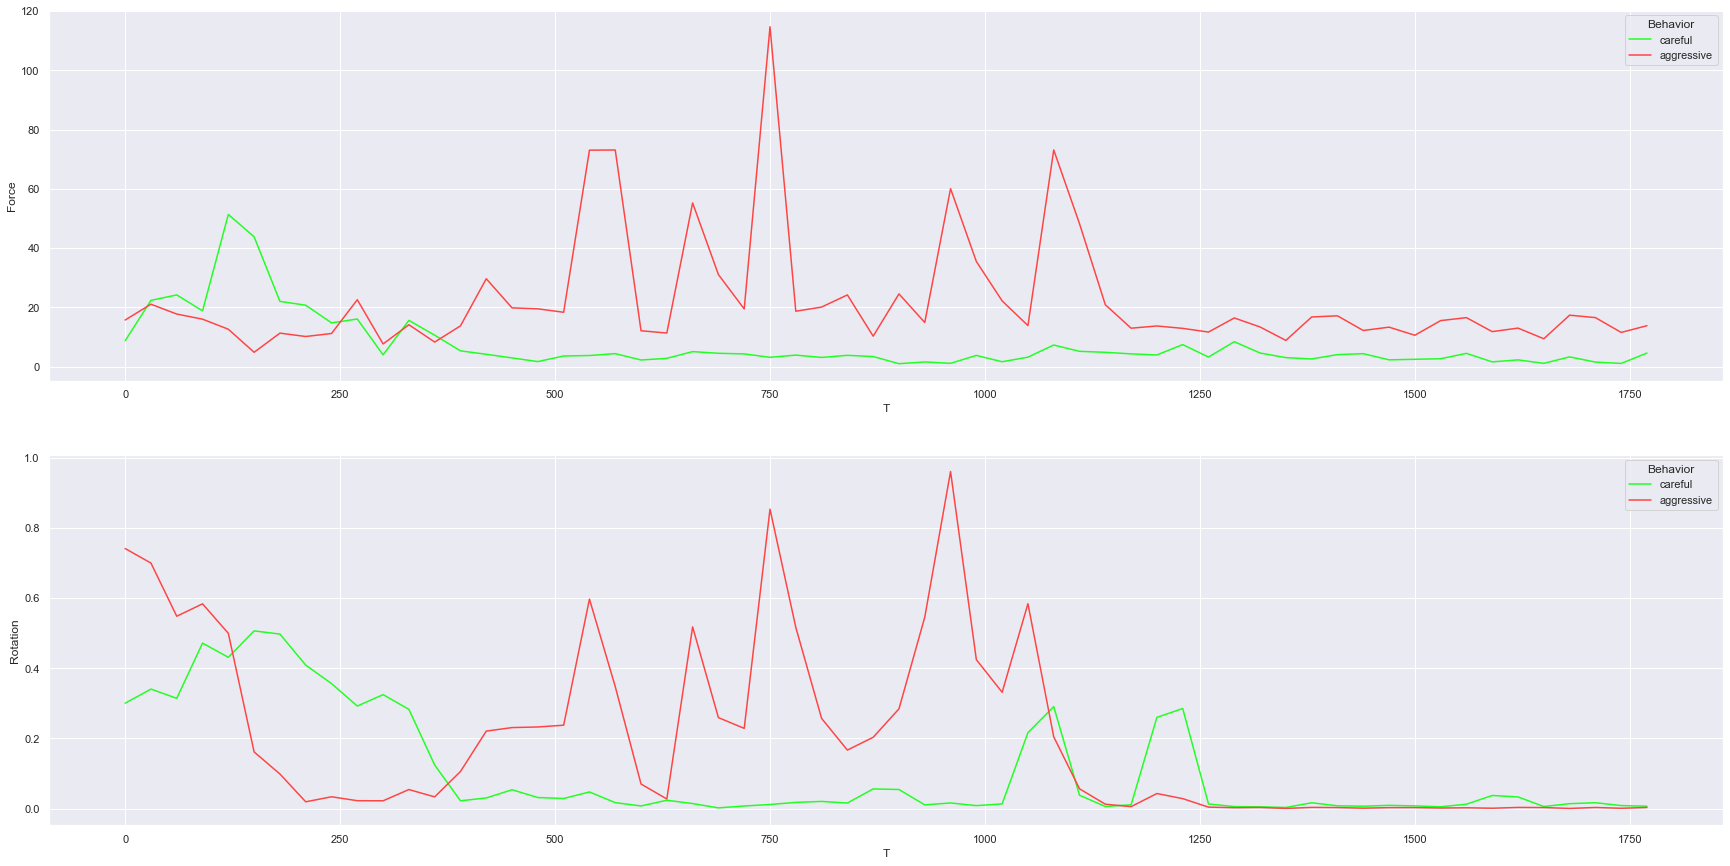

In [8]:
figure, ax = plt.subplots(2, 1, figsize=(30, 15))
pal = {'aggressive': '#FF4444', 'careful': '#22FF22'}
sns.lineplot(x='T', y='Force', hue='Behavior', data=df, palette=pal, ax=ax[0])
sns.lineplot(x='T', y='Rotation', hue='Behavior', data=df, palette=pal, ax=ax[1])